Let's check this glorious repo from R in Python
Some explanation here https://youtu.be/10pvXLKw5dQ
This file is also in /analysis with details.

Blogs:
1) Basic explanation ARIMA https://www.analyticsvidhya.com/blog/2018/08/auto-arima-time-series-modeling-python-r/
3) Comprehensive example is you would like to see what is ARIMA:
 https://datafai.com/auto-arima-using-pyramid-arima-python-package/

Library:
1) https://pypi.org/project/pmdarima/
2) http://alkaline-ml.com/pmdarima/0.9.0/setup.html

In [1]:
import sys
import os
from tqdm import tqdm
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
sys.path.insert(0, os.path.abspath('../../covid_forecast'))
from covid_forecast.utils.data_io import get_data, download_the_data
from covid_forecast.utils.visualizations import plt_arima_forecast,plt_arima_forecast_outsample, render_pic_in_notebook


# where to save things
OUTPUT = '../outputs/arima'
os.makedirs(OUTPUT,exist_ok=True)

In case you need to refresh the data, you need a folder /data. From www.ecdc.europa.eu.

In [2]:
download_the_data()

href="https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-23.xlsx"


# Load the data
Source www.ecdc.europa.eu

In [3]:
data = get_data()

In [4]:
# Quick look to the data. Source www.ecdc.europa.eu

In [5]:
data.head()

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-23,23,3,2020,10,0,Afghanistan,AF
1,2020-03-22,22,3,2020,0,0,Afghanistan,AF
2,2020-03-21,21,3,2020,2,0,Afghanistan,AF
3,2020-03-20,20,3,2020,0,0,Afghanistan,AF
4,2020-03-19,19,3,2020,0,0,Afghanistan,AF


In [6]:
data.describe()

,Day,Month,Year,Cases,Deaths
count,6368.000000,6368.000000,6368.000000,6368.000000,6368.000000
mean,15.459171,2.137249,2019.989479,53.126099,2.293028
std,8.048945,1.310697,0.102041,403.562845,23.302880
min,1.000000,1.000000,2019.000000,-9.000000,0.000000
25%,9.000000,1.000000,2020.000000,0.000000,0.000000
50%,16.000000,2.000000,2020.000000,0.000000,0.000000
75%,22.000000,3.000000,2020.000000,3.000000,0.000000
max,31.000000,12.000000,2020.000000,15141.000000,795.000000


# Countries to work with

In [7]:
data.columns

Index(['DateRep', 'Day', 'Month', 'Year', 'Cases', 'Deaths',
       'Countries and territories', 'GeoId'],
      dtype='object')

In [8]:
# All countries
# country_list = data['Countries and territories'].unique()
country_list = ['China', 'Italy', 'Germany', 'India', 'Spain', 'United_Kingdom', 'United_States_of_America',
                     'Lithuania', 'Cyprus']
country_list

['China',
 'Italy',
 'Germany',
 'India',
 'Spain',
 'United_Kingdom',
 'United_States_of_America',
 'Lithuania',
 'Cyprus']

# Where eveything happends

In [9]:
data = get_data()
report_country = pd.DataFrame()
report = pd.DataFrame()
for country in tqdm(country_list):
   
    print('Working on: {}'.format(country))
    first_variable = pd.DataFrame()
    for variable in ['Cases', 'Deaths']:
        try:
            data_ = data[data['Countries and territories'] == country].copy()
            data_ = data_.sort_values(by='DateRep')
            # Triming initial zeros
            remove_initia_zeros = np.trim_zeros(data_[variable]).__len__()
            # y = data_[variable][0:remove_initia_zeros]
            y = data_[variable][-remove_initia_zeros:]
            data_labels = data_['DateRep'][-remove_initia_zeros:]
            # taking the last 3. # Change it to any other amount
            lenght_for_forecast = 3
            # Fit your model
            model = pm.auto_arima(y, seasonal=False, suppress_warnings=True)
            # make your forecasts
            # predict N steps into the future
            forecasts, conf_int = model.predict(lenght_for_forecast, return_conf_int=True)
            # Adding labels for each new day
            data_labels = data_labels.to_list()
            for i in range(1,lenght_for_forecast+1):
                data_labels.append(data_labels[-1] + timedelta(1))
            forecasts, conf_int = model.predict(lenght_for_forecast, return_conf_int=True)
            # Visualize the forecasts (blue=train, green=forecasts)
            plt_arima_forecast_outsample(y, forecasts, conf_int=conf_int,
                       title=country,
                       y_label=variable,
                       x=data_labels,
                       save_here=OUTPUT + '/forecast_next_3days_{}_{}.png'.format(country, variable))
            # To save the data
            df_for_data = pd.DataFrame()
            df_for_data = pd.DataFrame(y.to_list()+forecasts.tolist(),
                columns=[variable])
            df_for_data['Countries and territories'] = country
            df_for_data['DateRep'] = data_labels
            if first_variable.empty:
                first_variable = df_for_data
            else:
                first_variable = first_variable.merge(df_for_data, on=('DateRep', 'Countries and territories'))
        except Exception as e: print(e)
    if report.empty:
        report = first_variable
    else:
        report = pd.concat([report, first_variable])
if report_country.empty:
    report_country = report
else:
    report_country = pd.concat([report_country, report])
# Creation of report
report_country.to_csv(OUTPUT+"/forecast_next_free_days.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

Working on: China


 11%|█         | 1/9 [00:05<00:42,  5.31s/it]

Working on: Italy


 22%|██▏       | 2/9 [00:12<00:40,  5.82s/it]

Working on: Germany


 33%|███▎      | 3/9 [00:16<00:31,  5.31s/it]

Working on: India


 44%|████▍     | 4/9 [00:20<00:25,  5.00s/it]

Working on: Spain


 56%|█████▌    | 5/9 [00:26<00:20,  5.23s/it]

Working on: United_Kingdom


 67%|██████▋   | 6/9 [00:32<00:16,  5.34s/it]

Working on: United_States_of_America


 78%|███████▊  | 7/9 [00:35<00:09,  4.85s/it]

Working on: Lithuania


/opt/anaconda3/envs/covid_forecast/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (2, 1, 3)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/opt/anaconda3/envs/covid_forecast/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:386: ModelFitWarning: Unable to fit ARIMA for (3, 1, 3)x(0, 0, 0, 0); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/opt/anaconda3/envs/covid_forecast/lib/python3.7/site-packages/pmdarima/arima/auto.py:328: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
 89%|████████▉ | 8/9 [00:38<00:04,  4.06s/it]

too many indices for array
Working on: Cyprus


/opt/anaconda3/envs/covid_forecast/lib/python3.7/site-packages/pmdarima/arima/auto.py:328: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
100%|██████████| 9/9 [00:40<00:00,  4.55s/it]


<Figure size 432x288 with 0 Axes>

# Now let see some of the pics
## Spain

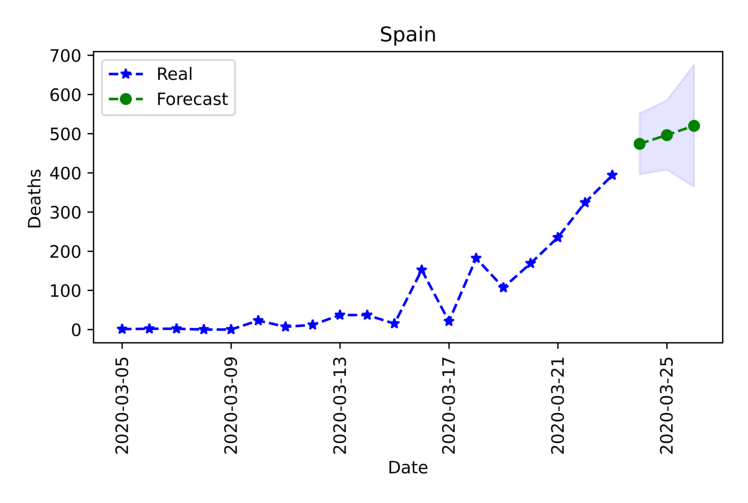

In [10]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_Spain_Deaths.png')

You can see the predictions at the top.

In [11]:
report_country[report_country['Countries and territories']=='Spain'].sort_values(by='DateRep',ascending = False).head()

,Cases,Countries and territories,DateRep,Deaths
21,6616.090854,Spain,2020-03-26,520.136297
20,4613.207151,Spain,2020-03-25,496.376932
19,5759.505853,Spain,2020-03-24,473.972512
18,3646.000000,Spain,2020-03-23,394.000000
17,4946.000000,Spain,2020-03-22,324.000000


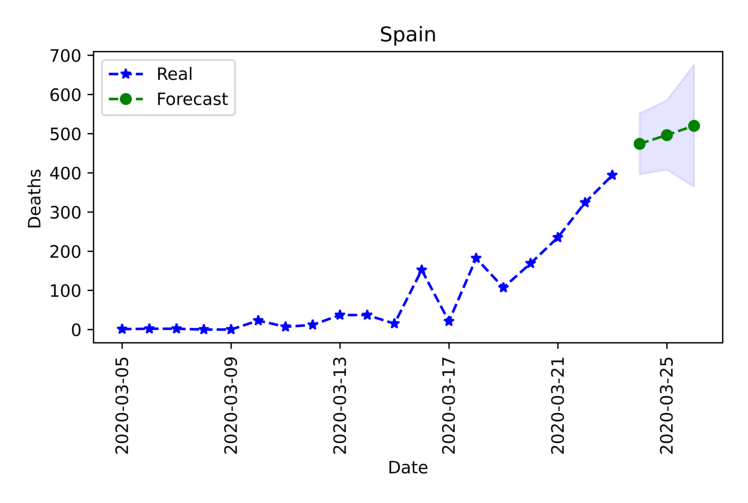

In [12]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_Spain_Deaths.png')

## United Kingdom

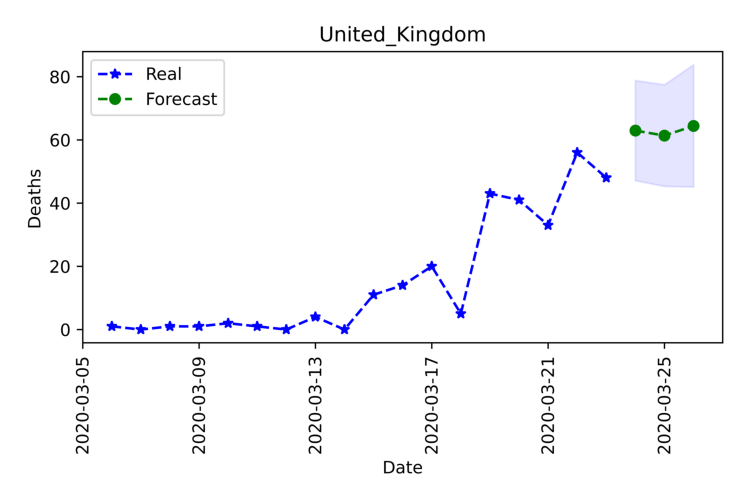

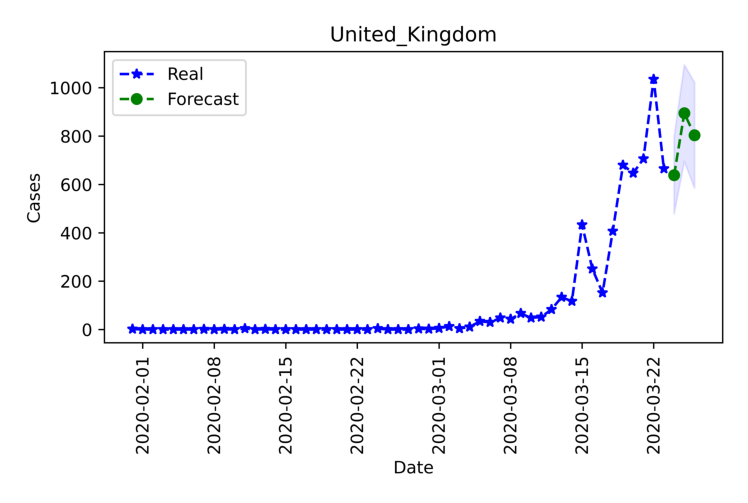

In [13]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_Kingdom_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_Kingdom_Cases.png')

## India

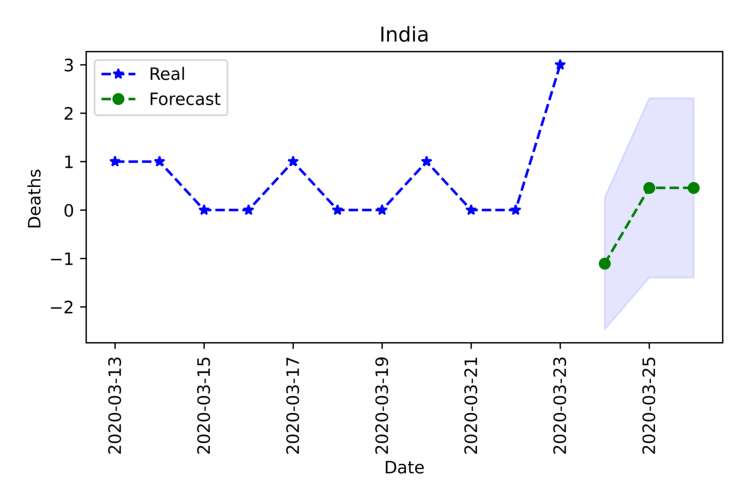

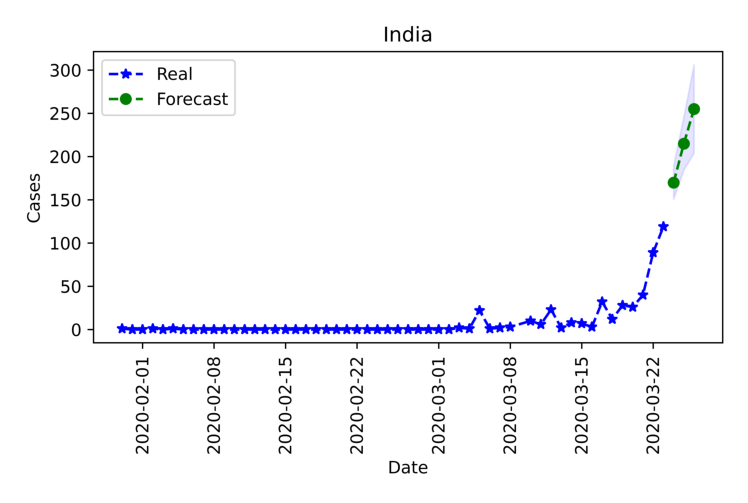

In [14]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_India_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_India_Cases.png')

## United_States_of_America

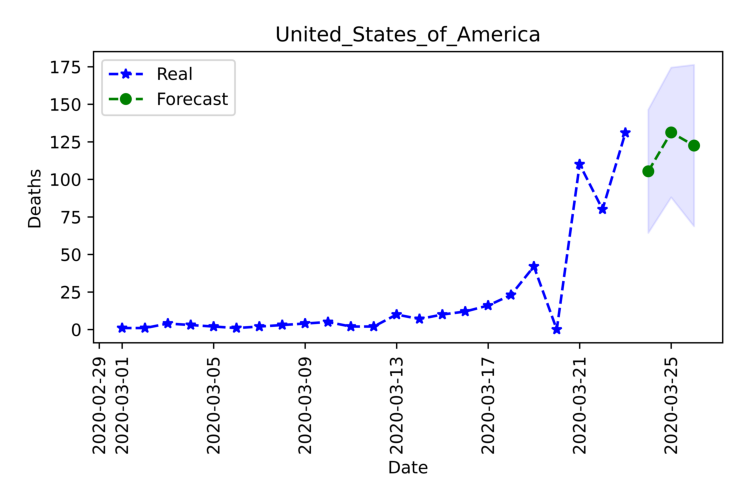

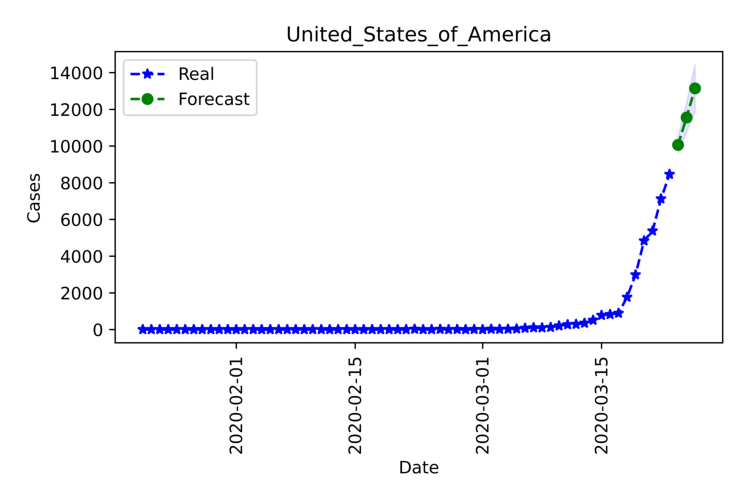

In [15]:
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_States_of_America_Deaths.png')
render_pic_in_notebook('../outputs/arima/forecast_next_3days_United_States_of_America_Cases.png')